(480, 640)
(480, 640)


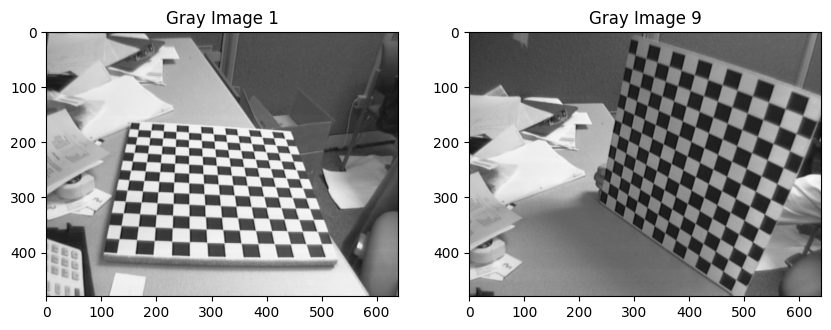

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the checkerboard images
image1_path = './Checkerboard Images/Image1.tif'
image9_path = './Checkerboard Images/Image9.tif'
image1 = cv2.imread(image1_path)
image9 = cv2.imread(image9_path)

# Convert to grayscale
gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
print(gray1.shape)
gray9 = cv2.cvtColor(image9, cv2.COLOR_BGR2GRAY)
print(gray9.shape)
plt.figure(figsize=(10,5))
plt.subplot(121), plt.imshow(gray1, cmap='gray'),plt.title('Gray Image 1')
plt.subplot(122), plt.imshow(gray9, cmap='gray'),plt.title('Gray Image 9')
plt.show()

In [5]:
# Find the chessboard corners
pattern_size = (9, 6)  # Update this if the internal corners count is different
corners_found_img1, corners1 = cv2.findChessboardCorners(gray1, (12,11), None)
corners_found_img9, corners9 = cv2.findChessboardCorners(gray9, (13,12), None)

In [32]:
def draw_chessboard_corners(image, corner_points):
    image_with_drawn_corners = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)  # Convert grayscale to BGR
    num_corners = len(corner_points)
    colors = plt.cm.rainbow(np.linspace(0, 1, num_corners))
    
    for i, point in enumerate(corner_points):
        x_coordinate, y_coordinate = np.intp(point.ravel())
        color = tuple(map(int, colors[i][:3] * 255))  # Convert to BGR format as integers
        cv2.circle(image_with_drawn_corners, (x_coordinate, y_coordinate), 3, color, -1)
    
    return image_with_drawn_corners

In [37]:
def draw_matches(image1, keypoints1, image2, keypoints2):
    # Convert images to BGR if they are grayscale
    if len(image1.shape) == 2:
        image1 = cv2.cvtColor(image1, cv2.COLOR_GRAY2BGR)
    if len(image2.shape) == 2:
        image2 = cv2.cvtColor(image2, cv2.COLOR_GRAY2BGR)

    # Create a new image by concatenating the two images side by side
    combined_image = np.hstack((image1, image2))
    
    # Draw lines between matched points
    for i in range(len(keypoints1)):
        pt1 = tuple(np.int32(keypoints1[i]))
        pt2 = tuple(np.int32(keypoints2[i]) + np.array([image1.shape[1], 0]))  # Shift x-coordinate for second image
        cv2.line(combined_image, pt1, pt2, (0, 255, 0), 1)

    return combined_image

In [ ]:
def compute_homography(points_img1, points_img2):
    hm = []
    for i in range(len(points_img1)):
        x, y = points_img1[i]
        xp, yp = points_img2[i]
        hm.append([-x, -y, -1, 0, 0, 0, xp*x, xp*y, xp])
        hm.append([0, 0, 0, -x, -y, -1, yp*x, yp*y, yp])

    hm = np.array(hm)
    U, S, Vh = np.linalg.svd(hm)
    H = Vh[-1].reshape(3, 3)
    return H

def normalize_points(points):
    mean = np.mean(points, axis=0)
    std = np.std(points)
    normalized_points = (points - mean) / std
    return normalized_points, mean, std

def apply_normalization(points, mean, std):
    return (points - mean) / std

def denormalize_homography(H, mean1, std1, mean2, std2):
    T1 = np.array([
        [std1, 0, mean1[0]],
        [0, std1, mean1[1]],
        [0, 0, 1]
    ])
    T2 = np.array([
        [1/std2, 0, -mean2[0]/std2],
        [0, 1/std2, -mean2[1]/std2],
        [0, 0, 1]
    ])
    return np.dot(np.dot(T2, H), T1)

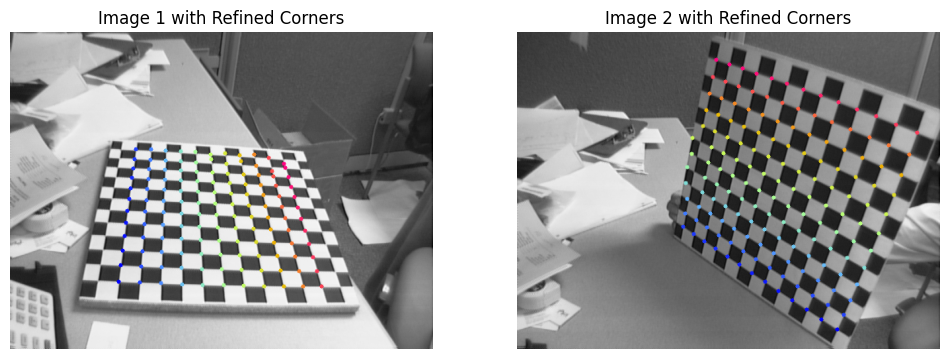

Homography matrix H:
[[ 2.98290031e-01  8.69796881e-01 -1.06926682e+02]
 [-6.50140411e-01  5.31436307e-01  1.91565134e+02]
 [-1.18070254e-03  5.18595863e-04  1.00000000e+00]]


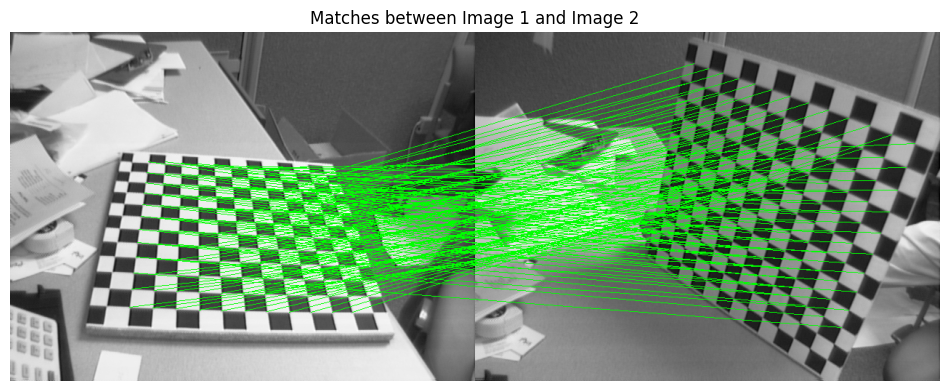

In [40]:
# If corners are found in both images, proceed to estimate the homography
if corners_found_img1 and corners_found_img9:
    # Refine the corner coordinates
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    refined_corners_img1 = cv2.cornerSubPix(gray1, corners1, (11, 11), (-1, -1), criteria)
    refined_corners_img9 = cv2.cornerSubPix(gray9, corners9, (11, 11), (-1, -1), criteria)

    # Ensure one-to-one correspondence between corner points
    reshaped_corners_img1 = refined_corners_img1.reshape(-1, 2)
    reshaped_corners_img9 = refined_corners_img9.reshape(-1, 2)

    # Draw the corners on the images
    img1_with_corners = draw_chessboard_corners(gray1, refined_corners_img1)
    img9_with_corners = draw_chessboard_corners(gray9, refined_corners_img9)

    # Display the images with the refined corners
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    images_with_corners = [img1_with_corners, img9_with_corners]
    
    for idx in range(2):
        axes[idx].imshow(cv2.cvtColor(images_with_corners[idx], cv2.COLOR_BGR2RGB))  # Display in color
        axes[idx].set_title(f"Image {idx + 1} with Refined Corners")
        axes[idx].axis('off')

    plt.show()

    # Manual selection of matching points
    num_matching_points = min(len(reshaped_corners_img1), len(reshaped_corners_img9))
    matching_points_img1 = reshaped_corners_img1[:num_matching_points]
    matching_points_img9 = reshaped_corners_img9[:num_matching_points]

    # Compute the homography matrix
    #homography_matrix, mask = cv2.findHomography(matching_points_img1, matching_points_img9, cv2.RANSAC)
    
    # Print matched points
    # print("Matched points in Image 1:")
    # print(matching_points_img1)
    # print("Matched points in Image 9:")
    # print(matching_points_img9)
    
    # Print homography matrix
    # print("Homography matrix H:")
    # print(homography_matrix)

    # Normalize points
    normalized_points_img1, mean1, std1 = normalize_points(matching_points_img1)
    normalized_points_img9, mean2, std2 = normalize_points(matching_points_img9)

    # Compute the homography matrix using normalized points
    H_normalized = compute_homography(normalized_points_img1, normalized_points_img9)
    
    # Denormalize the homography matrix
    H = denormalize_homography(H_normalized, mean1, std1, mean2, std2)
    
    # Normalize the homography matrix
    H /= H[2, 2]
    print("Computed Homography Matrix:")
    print(H)

    # Draw matches
    combined_image_with_matches = draw_matches(gray1, matching_points_img1, gray9, matching_points_img9)

    # Draw matches
    combined_image_with_matches = draw_matches(gray1, matching_points_img1, gray9, matching_points_img9)
    
    # Display matches
    plt.figure(figsize=(12, 6))
    plt.imshow(cv2.cvtColor(combined_image_with_matches, cv2.COLOR_BGR2RGB))
    plt.title("Matches between Image 1 and Image 2")
    plt.axis('off')
    plt.show()